In [1]:
# Animal classification
# https://www.kaggle.com/stpeteishii/animal-detection-by-yolo-coco-model

In [2]:
import math
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers
from tqdm import tqdm

In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
basedir = "archive/raw-img/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    basedir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    basedir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [111]:
model = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(
            1.0 / 255, input_shape=(img_height, img_width, 3)
        ),
        # layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        # layers.experimental.preprocessing.RandomRotation(0.1),
        layers.Conv2D(128, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(len(class_names), activation="softmax"),
    ]
)

In [112]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [113]:
model.fit(train_ds, validation_data=val_ds, epochs=2, batch_size=batch_size)

Epoch 1/2
655/655 [==============================] - 67s 102ms/step - loss: 2.0089 - accuracy: 0.2838 - val_loss: 1.3906 - val_accuracy: 0.5205
Epoch 2/2
655/655 [==============================] - 68s 104ms/step - loss: 1.3669 - accuracy: 0.5398 - val_loss: 1.2280 - val_accuracy: 0.5870


In [114]:
loss, acc = model.evaluate(val_ds)
print("Accuracy", acc)

164/164 [==============================] - 11s 69ms/step - loss: 1.2280 - accuracy: 0.5870
Accuracy 0.5870105028152466


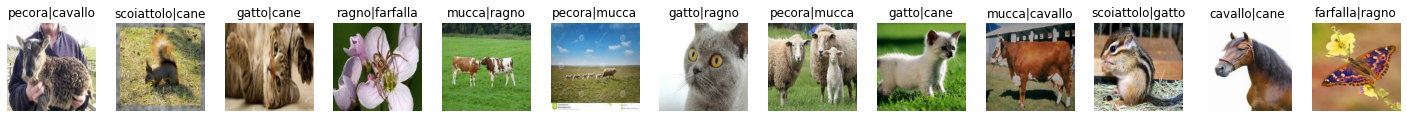

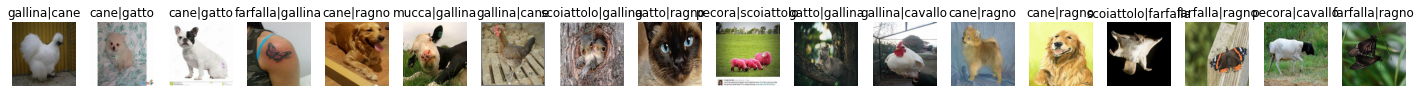

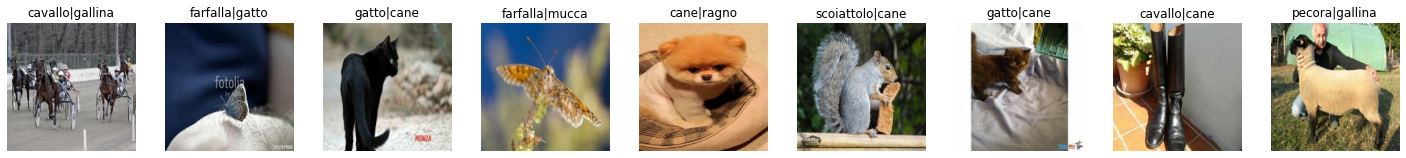

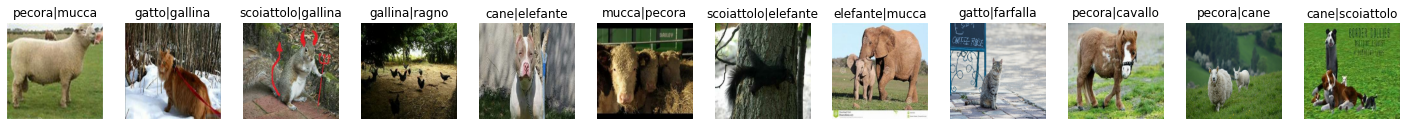

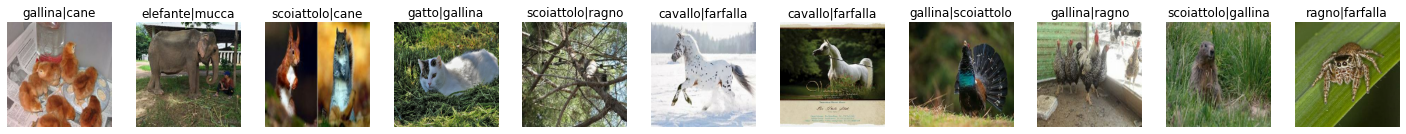

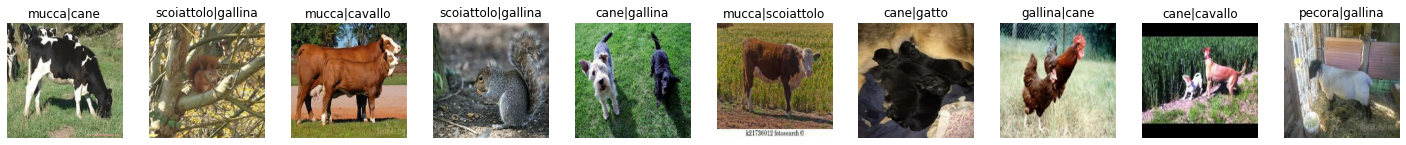

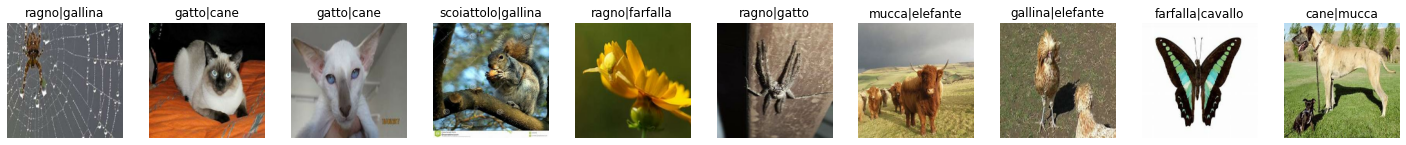

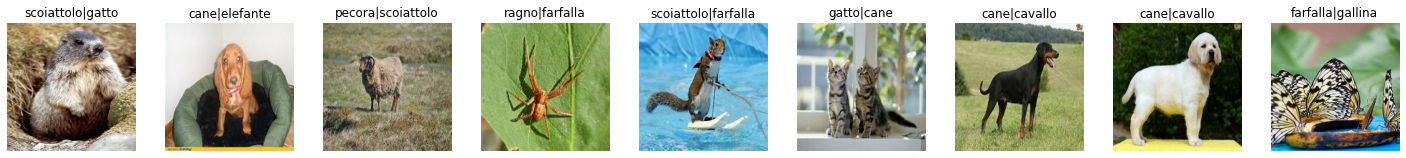

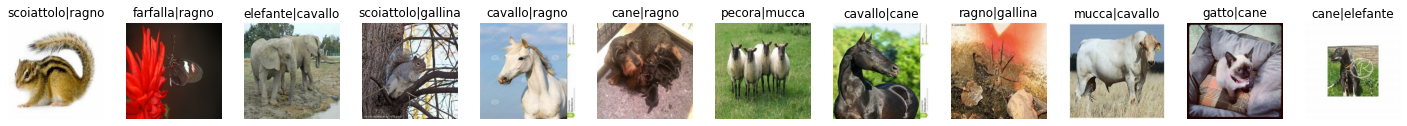

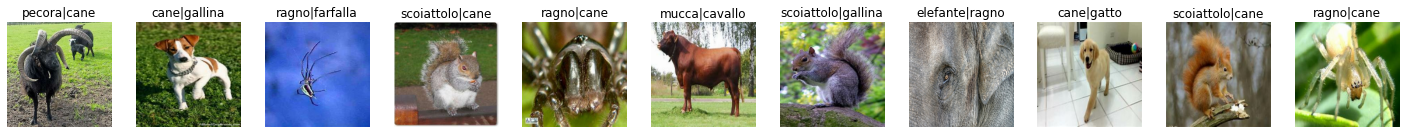

In [128]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(10):

    fig = plt.figure(figsize=(25, 25))
    pred_prob = [(np.argmax(p),max(p)) for p in model.predict(images)]
    predictions = [class_names[a[0]] for a in pred_prob]
    expected = [class_names[a] for a in labels]
    not_match = [i for i in range(len(predictions)) if predictions[i] != expected[i]]
    rows = columns = int(math.ceil(len(not_match)))
    for i in range(len(not_match)):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(images[not_match[i]].numpy().astype("uint8"))
        plt.title("{}|{}".format(expected[not_match[i]], predictions[not_match[i]]))
        plt.axis("off")